In [1]:
import numpy as np
from tensorflow import keras  
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express  as px
import plotly.io as pio
pio.renderers.default = 'vscode'


2025-01-11 07:10:51.504174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-11 07:10:51.653264: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-11 07:10:51.797735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736572251.933036    1617 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736572251.973149    1617 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 07:10:52.262676: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
raw_data = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/Rice_Cammeo_Osmancik.csv')

In [3]:
raw_data.describe(include='all')

Area    Perimeter  Major_Axis_Length  Minor_Axis_Length  \
count    3810.000000  3810.000000        3810.000000        3810.000000   
unique           NaN          NaN                NaN                NaN   
top              NaN          NaN                NaN                NaN   
freq             NaN          NaN                NaN                NaN   
mean    12667.727559   454.239180         188.776222          86.313750   
std      1732.367706    35.597081          17.448679           5.729817   
min      7551.000000   359.100006         145.264465          59.532406   
25%     11370.500000   426.144753         174.353855          82.731695   
50%     12421.500000   448.852493         185.810059          86.434647   
75%     13950.000000   483.683746         203.550438          90.143677   
max     18913.000000   548.445984         239.010498         107.542450   

        Eccentricity   Convex_Area       Extent     Class  
count    3810.000000   3810.000000  3810.000000      3810  
unique           NaN           NaN          NaN         2  
top              NaN           NaN          NaN  Osmancik  
freq             NaN           NaN          NaN      2180  
mean        0.886871  12952.496850     0.661934       NaN  
std         0.020818   1776.972042     0.077239       NaN  
min         0.777233   7723.000000     0.497413       NaN  
25%         0.872402  11626.250000     0.598862       NaN  
50%         0.889050  12706.500000     0.645361       NaN  
75%         0.902588  14284.000000     0.726562       NaN  
max         0.948007  19099.000000     0.861050       NaN

# Exploring Data

### Visualization

In [4]:
for x_axis, y_axis in [('Area','Eccentricity'),
                       ('Convex_Area', 'Perimeter'),
                        ('Major_Axis_Length', 'Minor_Axis_Length'),
                        ('Perimeter', 'Extent'),
                        ('Eccentricity', 'Major_Axis_Length')]:
    px.scatter(raw_data, x=x_axis, y= y_axis, color='Class').show()

In [5]:
px.scatter_3d(raw_data, x='Major_Axis_Length',y='Convex_Area',z='Eccentricity', color='Class')

In [6]:
px.scatter_3d(raw_data, x='Major_Axis_Length',y='Convex_Area',z='Perimeter', color='Class')

In [7]:
px.scatter_3d(raw_data, x='Area',y='Convex_Area',z='Eccentricity', color='Class')

### Normalization

In [4]:
raw_data.head()

Area   Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  15231  525.578979         229.749878          85.093788      0.928882   
1  14656  494.311005         206.020065          91.730972      0.895405   
2  14634  501.122009         214.106781          87.768288      0.912118   
3  13176  458.342987         193.337387          87.448395      0.891861   
4  14688  507.166992         211.743378          89.312454      0.906691   

   Convex_Area    Extent   Class  
0        15617  0.572896  Cammeo  
1        15072  0.615436  Cammeo  
2        14954  0.693259  Cammeo  
3        13368  0.640669  Cammeo  
4        15262  0.646024  Cammeo

In [5]:
feature_mean = raw_data.mean(numeric_only=True)
feature_std = raw_data.std(numeric_only=True)
numeric_columns = raw_data.select_dtypes('number').columns
normalized = raw_data.copy()
normalized[numeric_columns] = (normalized[numeric_columns] - feature_mean)/feature_std


In [6]:
normalized.head()

Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
0  1.479635   2.004091           2.348238          -0.212915      2.018073   
1  1.147720   1.125705           0.988261           0.945444      0.409964   
2  1.135020   1.317041           1.451718           0.253854      1.212797   
3  0.293398   0.115285           0.261405           0.198025      0.239720   
4  1.166191   1.486858           1.316269           0.523351      0.952096   

   Convex_Area    Extent   Class  
0     1.499463 -1.152770  Cammeo  
1     1.192761 -0.602000  Cammeo  
2     1.126356  0.405558  Cammeo  
3     0.233826 -0.275315  Cammeo  
4     1.299685 -0.205986  Cammeo

In [7]:
keras.utils.set_random_seed(42)

In [8]:
normalized['Class_Encoded'] = normalized['Class'].map({'Osmancik':0,'Cammeo':1})

### Splitting Data

In [9]:
rows_number = len(normalized)
index_80th = round(rows_number * 0.8)
index_90th = index_80th + round(rows_number * 0.1)

shuffled_dataset = normalized.sample(frac=1, random_state=100, ignore_index=True)
train_data = shuffled_dataset.iloc[:index_80th]
val_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

In [10]:
test_data.tail(10)

Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
3800  1.514847   1.580012           1.769922           0.492055      1.301805   
3801  1.424797   1.809272           1.887414           0.330531      1.468883   
3802 -1.284789  -1.319130          -1.297216          -0.920531     -0.667691   
3803 -0.252099  -0.103385          -0.070726          -0.397159      0.341617   
3804  0.978587   1.262233           1.230427           0.313802      1.012326   
3805 -1.009444  -1.156224          -1.240794          -0.365661     -1.110679   
3806  1.976066   1.533604           1.169582           2.254523     -0.314541   
3807 -1.411783  -0.863615          -0.342489          -2.476423      1.537296   
3808 -0.549957  -0.704361          -1.013061           0.487545     -1.594168   
3809 -1.120275  -0.796053          -0.576651          -1.532738      0.678505   

      Convex_Area    Extent     Class  Class_Encoded  
3800     1.439811 -1.537310    Cammeo              1  
3801     1.416175 -1.711857    Cammeo              1  
3802    -1.285612 -0.073794  Osmancik              0  
3803    -0.252394  0.585505  Osmancik              0  
3804     0.965971 -0.713125    Cammeo              1  
3805    -1.031247 -0.285464  Osmancik              0  
3806     1.957545  0.110363    Cammeo              1  
3807    -1.424613  2.051446  Osmancik              0  
3808    -0.498881 -0.160538  Osmancik              0  
3809    -1.121288 -1.263520    Cammeo              1

In [11]:
label_columns = ['Class', 'Class_Encoded']

train_features = train_data.drop(columns = label_columns)
train_labels = train_data['Class_Encoded'].to_numpy()
val_features = val_data.drop(columns= label_columns)
val_labels = val_data['Class_Encoded'].to_numpy()
test_features = test_data.drop(columns = label_columns)
test_labels = test_data['Class_Encoded'].to_numpy()

# Building model

In [12]:
input_features = ['Major_Axis_Length','Convex_Area','Perimeter']

In [13]:
import dataclasses

@dataclasses.dataclass()
class ExperimentSettings:
    learning_rate: float
    number_epochs: int
    batch_size: int
    threshold: float
    features: list[str]

@dataclasses.dataclass()
class Experiment:
    name: str
    settings: ExperimentSettings
    epochs: np.ndarray
    model: keras.Model
    metrics_history: keras.callbacks.History
    def get_final_metric_value(self, metric_name:str) -> float:
        if metric_name not in self.metrics_history:
            raise ValueError (
                f'Unknown metric {metric_name}: available metrics are'
                f'{list(self.metrics_history.columns)}'
            )
        return self.metrics_history[metric_name].iloc[-1]
    
def create_model(settings: ExperimentSettings,
                 metrics: list[keras.metrics.Metric],
                 optimizer: keras.optimizers) -> keras.Model :
    model_inputs = [keras.Input(name=feature, shape=(1,)) for feature in settings.features]
    concatinated_inputs = keras.layers.Concatenate()(model_inputs)
    dense = keras.layers.Dense(name='dense_layer', units=1 ,activation=keras.activations.sigmoid)
    model_output = dense(concatinated_inputs)
    model = keras.Model(inputs=model_inputs,outputs=model_output)

    model.compile(
        optimizer= optimizer(settings.learning_rate),
        loss= keras.losses.BinaryCrossentropy(),
        metrics= metrics
    )
    return model
def train_model(
        experiment_name:str,
        settings: ExperimentSettings,
        model: keras.Model,
        dataset: pd.DataFrame,
        labels: np.ndarray) -> Experiment:
    features = {feature_name: np.array(dataset[feature_name]) for feature_name in settings.features}
    history = model.fit(x= features,y=labels, epochs= settings.number_epochs, batch_size= settings.batch_size)
    return Experiment(name=experiment_name, settings=settings,epochs=settings.number_epochs,model=model,metrics_history=pd.DataFrame(history.history))



### Plot Metrics

In [14]:
def plot_metrics(experiment:Experiment,
                 metrics:list[str]):
    for metric in metrics:
        plt.plot(np.arange(experiment.epochs),experiment.metrics_history[metric],label=metric)
    plt.xlabel('epochs')
    plt.ylabel('metric value')
    plt.grid()
    plt.legend()

Epoch 1/60


W0000 00:00:1736572276.336513    1617 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/abdo/.local/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['Major_Axis_Length', 'Convex_Area', 'Perimeter']. Received: the structure of inputs={'Major_Axis_Length': '*', 'Convex_Area': '*', 'Perimeter': '*'}



31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - AUC: 0.9618 - accuracy: 0.7344 - loss: 0.4266 - precision: 0.6253 - recall: 0.9884
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.9625 - accuracy: 0.7730 - loss: 0.4068 - precision: 0.6622 - recall: 0.9870
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9640 - accuracy: 0.7951 - loss: 0.3888 - precision: 0.6862 - recall: 0.9843
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9648 - accuracy: 0.8096 - loss: 0.3737 - precision: 0.7023 - recall: 0.9807
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9651 - accuracy: 0.8256 - loss: 0.3596 - precision: 0.7231 - recall: 0.9773
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - AUC: 0.9657 - accuracy: 0.8439 - loss: 0.3464 - precision: 0.7472 - recall: 0.9747
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9666 - accuracy: 0.8586 - loss: 0.3339 - precision: 0.7669 - recall: 0.9714
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9666

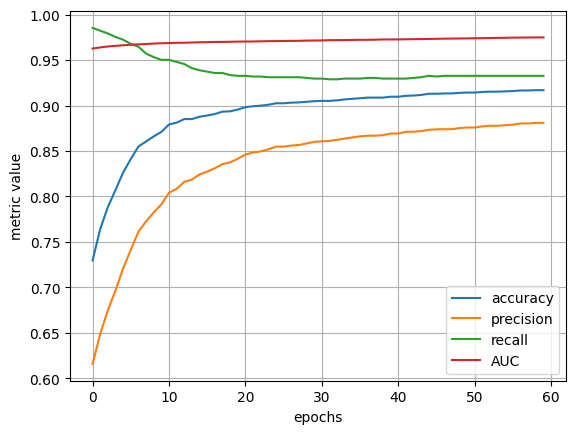

In [15]:
settings = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    threshold=0.35,
    features=input_features
)
metrics = [keras.metrics.BinaryAccuracy(name='accuracy', threshold=settings.threshold),
           keras.metrics.Precision(name='precision', thresholds=settings.threshold),
           keras.metrics.Recall(name='recall', thresholds=settings.threshold),
           keras.metrics.AUC(name='AUC', num_thresholds=100)]
model = create_model(settings=settings, metrics=metrics, optimizer=keras.optimizers.RMSprop)
exp = train_model('test1',settings=settings,model=model, dataset=train_data, labels=train_labels)
plot_metrics(experiment=exp,metrics=['accuracy','precision','recall','AUC'])

# Evaluation

In [16]:
def evaluate_model (experiment: Experiment, test_dataset: pd.DataFrame, test_labels:np.ndarray) -> dict[str,float]:
    test_features = {feature_name: np.array(test_dataset[feature_name]) for feature_name in experiment.settings.features}
    return experiment.model.evaluate(x=test_features, y=test_labels,batch_size = settings.batch_size,return_dict = True)
def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


In [17]:
test_metrics = evaluate_model(exp,test_data,test_labels)
compare_train_test(exp, test_metrics)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - AUC: 0.9797 - accuracy: 0.9120 - loss: 0.1812 - precision: 0.8531 - recall: 0.9412
Comparing metrics between train and test:
------
Train AUC: 0.9751
Test AUC:  0.9731
------
Train accuracy: 0.9170
Test accuracy:  0.9108
------
Train loss: 0.1973
Test loss:  0.2000
------
Train precision: 0.8810
Test precision:  0.8687
------
Train recall: 0.9328
Test recall:  0.9145


# Training on all features

In [18]:
all_features = list(train_data.columns[:-2])

Epoch 1/60


/home/abdo/.local/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']. Received: the structure of inputs={'Area': '*', 'Perimeter': '*', 'Major_Axis_Length': '*', 'Minor_Axis_Length': '*', 'Eccentricity': '*', 'Convex_Area': '*', 'Extent': '*'}



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9608 - accuracy: 0.8548 - loss: 0.3284 - precision: 0.7606 - recall: 0.9651
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9663 - accuracy: 0.8479 - loss: 0.3049 - precision: 0.7514 - recall: 0.9786
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9698 - accuracy: 0.8591 - loss: 0.2868 - precision: 0.7665 - recall: 0.9798
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.9722 - accuracy: 0.8707 - loss: 0.2711 - precision: 0.7820 - recall: 0.9775
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - AUC: 0.9738 - accuracy: 0.8797 - loss: 0.2579 - precision: 0.7958 - recall: 0.9763
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.9747 - accuracy: 0.8847 - loss: 0.2474 - precision: 0.8037 - recall: 0.9755
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9759 - accuracy: 0.8915 - loss: 0.2363 - precision: 0.8155 - recall: 0.9724
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9766 - 

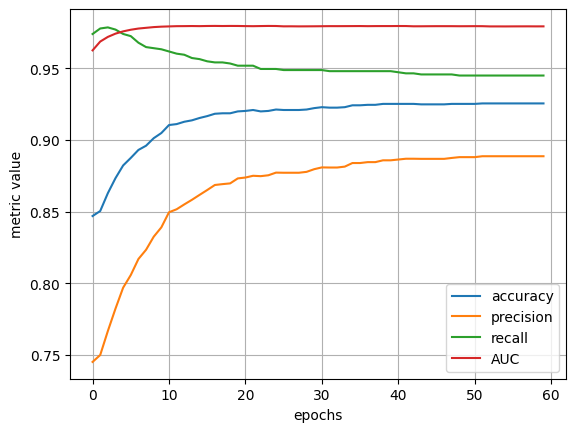

In [19]:
settings2 = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    threshold=0.35,
    features=all_features
)
model2 = create_model(settings=settings2,metrics=metrics, optimizer=keras.optimizers.RMSprop)
exp2 = train_model(experiment_name='On all features', settings=settings2, model=model2,dataset=train_data,labels=train_labels)
plot_metrics(experiment=exp2,metrics=['accuracy','precision','recall','AUC'])

In [20]:
test_metrics2 = evaluate_model(exp2,test_data,test_labels)
compare_train_test(exp2, test_metrics2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - AUC: 0.9810 - accuracy: 0.9026 - loss: 0.1758 - precision: 0.8348 - recall: 0.9429 
Comparing metrics between train and test:
------
Train AUC: 0.9793
Test AUC:  0.9766
------
Train accuracy: 0.9255
Test accuracy:  0.9081
------
Train loss: 0.1793
Test loss:  0.1889
------
Train precision: 0.8886
Test precision:  0.8589
------
Train recall: 0.9450
Test recall:  0.9211


In [21]:
pred = model2.predict(dict(zip(all_features,np.array([[1.381],[1.21],[1.07],[1.2],[0.4],[1.22],[0.9]]))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [22]:
pred

array([[0.99008375]], dtype=float32)

# Manual Logistic Regression

### Automatic SGD

In [94]:
settings_SGD = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=1000,
    batch_size=3048,
    threshold=0.35,
    features=['Major_Axis_Length']
)
autoSGD = create_model(settings=settings_SGD,metrics=metrics, optimizer=keras.optimizers.SGD)
exp_SGD = train_model('exp_SGD', settings=settings_SGD,model=autoSGD,dataset=train_data,labels=train_labels)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - AUC: 0.7234 - accuracy: 0.6304 - loss: 0.7063 - precision: 0.5376 - recall: 0.9962
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.0688 - accuracy: 0.4295 - loss: 0.7061 - precision: 0.4295 - recall: 1.0000
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.0718 - accuracy: 0.4295 - loss: 0.7060 - precision: 0.4295 - recall: 1.0000
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.0730 - accuracy: 0.4295 - loss: 0.7058 - precision: 0.4295 - recall: 1.0000
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.0743 - accuracy: 0.4295 - loss: 0.7056 - precision: 0.4295 - recall: 1.0000
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.0763 - accuracy: 0.4295 - loss: 0.7054 - precision: 0.4295 - recall: 1.0000
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.0785 - accuracy: 0.4295 - loss: 0.7052 - precision: 0.4295 - recall: 1.0000
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/s

### Manual SGD

In [23]:
major_axis = train_data['Major_Axis_Length']
train_labels

array([0, 0, 1, ..., 0, 0, 0])

[np.float64(0.22353428353026472), np.float64(0.21643684462618634), np.float64(0.2109908134077579), np.float64(0.20669795037757027), np.float64(0.2032413985511589)]


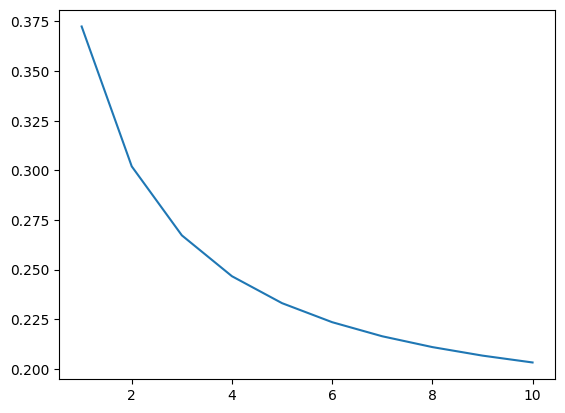

In [89]:
w,b = np.random.rand(1),np.random.rand(1)
lr = 0.001
epochs = 10
loss_track = []

for iteration in range(epochs):
    in_loss =[]
    for sample in range(len(major_axis)):
        z = w * major_axis[sample] + b
        y_hat = 1/(1+np.e**-z)
        loss = (-train_labels[sample]*np.log(y_hat))-((1-train_labels[sample])*np.log(1-y_hat))
        in_loss.append(loss)

        dw = (y_hat-train_labels[sample])*major_axis[sample]
        db = y_hat-train_labels[sample]

        w = w - lr*dw
        b = b - lr*db
    loss_track.append(np.mean(in_loss))
print(loss_track[-5:])
plt.plot(range(1,len(loss_track)+1),loss_track)

### Manual Full Batch

[np.float64(0.3442277670764047), np.float64(0.3440887840248494), np.float64(0.3439498968799565), np.float64(0.3438111055519227), np.float64(0.3436724099510498)]


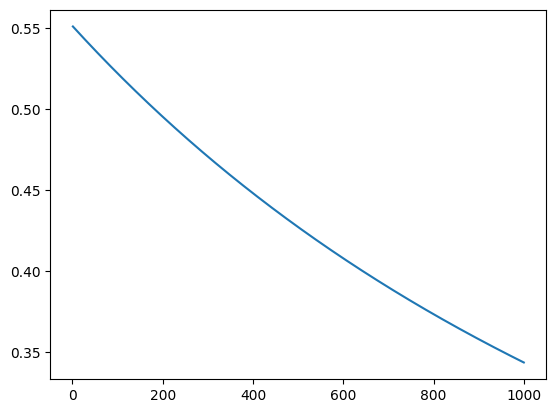

In [93]:
w,b = np.random.rand(1),np.random.rand(1)
lr = 0.001
epochs = 1000
loss_track = []

for epoch in range(epochs):
    z = w * major_axis + b
    y_hat = 1/(1+np.e**-z)
    loss = (-train_labels*np.log(y_hat))-((1-train_labels)*np.log(1-y_hat))
    loss_track.append(np.mean(loss))
    dw = (y_hat-train_labels)*major_axis
    db = y_hat-train_labels
    w = w - lr*dw
    b = b - lr*db

print(loss_track[-5:])
plt.plot(range(1,len(loss_track)+1),loss_track)

# Using sklearn

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [123]:
sci_model = LogisticRegression(verbose=1)
sci_model.fit(major_axis.to_numpy().reshape(-1,1),train_labels)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  4.12416D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F


 This problem is unconstrained.


LogisticRegression(verbose=1)

    2      8      9      1     0     0   1.537D-05   1.844D-01
  F =  0.18440518686889121     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [111]:
y_pred_proba = sci_model.predict_proba(major_axis.values.reshape(-1,1)) 
loss = log_loss(train_labels, y_pred_proba) 
print(f'Log Loss: {loss}')

Log Loss: 0.18099620058282148


-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.001000, T: 2, Avg. loss: 0.692905
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.001499, T: 1, Avg. loss: 0.691585
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.001998, T: 1, Avg. loss: 0.691865
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.001499, T: 1, Avg. loss: 0.692555
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.001998, T: 1, Avg. loss: 0.691955
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.002497, T: 1, Avg. loss: 0.690293
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.002995, T: 1, Avg. loss: 0.689961
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.00, NNZs: 1, Bias: -0.003493, T: 1, Avg. loss: 0.690058
Total training time: 0.00 seconds.
-- Epoch 1
Norm: 0.01, NNZs: 1, Bias: -0.003991, T: 1, Avg. loss: 0.689055
Total training time: 0.00 seconds.
-- Epoch 1

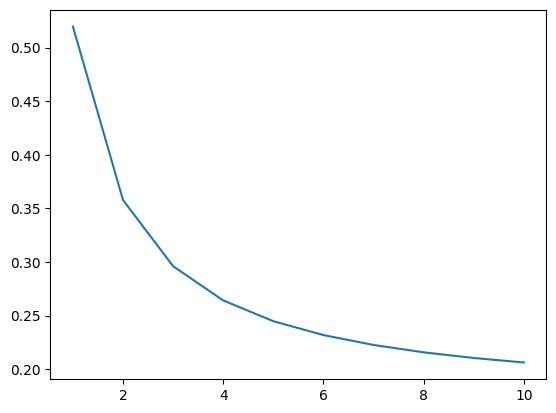

In [122]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

np.random.seed(42)


model = SGDClassifier(
    loss='log_loss',          
    penalty=None,       
    learning_rate='constant',
    eta0=0.001,          
    random_state=42,
    verbose=1
)


loss_track = []


model.partial_fit(major_axis.values.reshape(-1,1)[0:2], train_labels[0:2], classes=[0, 1])
epochs = 10

for epoch in range(epochs):
    in_loss = []
    for i in range(len(major_axis)):
        X_sample = major_axis[i].reshape(1, -1)
        y_sample = train_labels[i]
        
        model.partial_fit(X_sample, [y_sample])
        
        y_pred_proba = model.predict_proba(X_sample)[0, 1]
        loss = log_loss([y_sample], [y_pred_proba], labels=[0, 1])
        in_loss.append(loss)
    print(f"Mean loss after epoch: {np.mean(in_loss)}")
    loss_track.append(np.mean(in_loss))
    

plt.plot(range(1,len(loss_track)+1),loss_track)


In [ ]:
model = SGDClassifier(
    loss='log_loss',         
    penalty=None,       
    learning_rate='constant',
    eta0=0.001,         
    random_state=42,
    verbose=1
)

model.fit(major_axis.values.reshape(-1,1), train_labels)

-- Epoch 1
Norm: 0.90, NNZs: 1, Bias: -0.155335, T: 3048, Avg. loss: 0.520664
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.41, NNZs: 1, Bias: -0.247585, T: 6096, Avg. loss: 0.358285
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.76, NNZs: 1, Bias: -0.305142, T: 9144, Avg. loss: 0.296316
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.03, NNZs: 1, Bias: -0.348988, T: 12192, Avg. loss: 0.264300
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.25, NNZs: 1, Bias: -0.383053, T: 15240, Avg. loss: 0.244916
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.42, NNZs: 1, Bias: -0.409599, T: 18288, Avg. loss: 0.231954
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 2.58, NNZs: 1, Bias: -0.434657, T: 21336, Avg. loss: 0.222709
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 2.71, NNZs: 1, Bias: -0.456794, T: 24384, Avg. loss: 0.215816
Total training time: 0.00 seconds.
-- Epoch 9
Norm: 2.83, NNZs: 1, Bias: -0.473442, T: 27432, Avg. loss: 0.210518
Total traini

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss',
              penalty=None, random_state=42, verbose=1)

In [125]:
y_pred_proba = model.predict_proba(major_axis.values.reshape(-1,1)) 
loss = log_loss(train_labels, y_pred_proba) 
print(f'Log Loss: {loss}')

Log Loss: 0.1865491412795274
